## Importamos librerías

In [ ]:
# Manipulación de datos

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para clasificadores

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # Support Vector Classification model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.naive_bayes import GaussianNB

# Otras librerías

from sklearn.model_selection import train_test_split, RepeatedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_val_score # for splitting the data into train and test samples
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc  # for model evaluation metrics
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tabulate import tabulate
import xgboost as xgb

# MLP
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping



## Conectar con Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cargamos los datos

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/UAX/4º/TFG/TFG/Código /transactions_cleaned.csv')
df.head()

,creditLimit,availableMoney,transactionAmount,posEntryMode,posConditionCode,currentBalance,isFraud,CVV_match,transactionYear,transactionMonth,...,acqCountry_PR,acqCountry_US,expirationDateKeyInMatch_False,expirationDateKeyInMatch_True,cardPresent_False,cardPresent_True,transactionType_ADDRESS_VERIFICATION,transactionType_Información no disponible,transactionType_PURCHASE,transactionType_REVERSAL
0,5000,5000.0,98.55,2.0,1.0,0.0,0,1,2016,8,...,0,1,1,0,1,0,0,0,1,0
1,5000,5000.0,74.51,9.0,1.0,0.0,0,1,2016,10,...,0,1,1,0,0,1,0,0,1,0
2,5000,5000.0,7.47,9.0,1.0,0.0,0,1,2016,11,...,0,1,1,0,1,0,0,0,1,0
3,5000,5000.0,7.47,9.0,1.0,0.0,0,1,2016,12,...,0,1,1,0,1,0,0,0,1,0
4,5000,5000.0,71.18,2.0,1.0,0.0,0,1,2016,3,...,0,1,1,0,0,1,0,0,1,0


# Dividir entre X e Y

In [ ]:
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar los datos

Se va a proceder a escalar los datos con el objetivo de mejorar la predicción.

El objetivo de escalar los datos es reducir la diferencia en la magnitud de los daots para que todas las características aporten valor al modelo.

Solo se escalan los valores que no son binarios

Se va a usar `StandardScaler`para poder escalar los datos de forma correcta

In [ ]:
scaler = StandardScaler()

Aplicamos el escalador solo a las columnas no binarias en el entrenamiento y en el conjunto de datos

In [ ]:
columns_no_binary = ['creditLimit', 'availableMoney', 'transactionAmount', 'posEntryMode', 'posConditionCode', 'currentBalance', 'transactionYear', 'transactionMonth', 'transactionDay', 'transactionHour', 'days_since_last_address_change']

In [ ]:
X_train_scaled = X_train.copy()
X_train_scaled[columns_no_binary] = scaler.fit_transform(X_train[columns_no_binary])
X_test_scaled = X_test.copy()
X_test_scaled[columns_no_binary] = scaler.transform(X_test[columns_no_binary])

### Función curva ROC

In [ ]:
def plot_roc_curve(model, X_test, y_test):
    """
    Esta función grafica la curva ROC para un modelo dado y conjunto de prueba.

    Args:
    model: modelo entrenado de scikit-learn.
    X_test: numpy array o dataframe de pandas con los datos de prueba.
    y_test: array o serie de pandas con las etiquetas verdaderas.
    """
    # Obtener las probabilidades de las clases
    y_scores = model.predict_proba(X_test)[:, 1]

    # Calcular FPR, TPR, y umbrales
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    # Calcular el AUC
    roc_auc = auc(fpr, tpr)

    # Crear la figura para el plot
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend(loc="lower right", title='Leyenda')
    plt.show()

    return roc_auc  # Opcional, retorna el AUC en caso de que se quiera utilizar


# Modelos para la Clasificación

Creamos un diccionario, donde vamos a ir guardando los datos de validación de cada modelo

In [ ]:
results = {}

## Regresión Logística

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Definir el modelo de Regresión Logística
model_LR = LogisticRegression()

# Definir los parámetros que deseas explorar en Grid Search
parameters = {
    'penalty': ['l1', 'l2'],         # Tipo de regularización (L1 y L2)
    'C': [0.001, 0.01, 0.1, 1, 10]   # Parámetro de regularización
}

In [ ]:
grid_search_LR = GridSearchCV(estimator=model_LR, param_grid=parameters, cv=5, scoring='accuracy')
grid_search_LR.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [ ]:
# Mostrar los mejores parámetros y el mejor score obtenido
print("Mejores parámetros encontrados:")
print(grid_search_LR.best_params_)

Mejores parámetros encontrados:
{'C': 0.01, 'penalty': 'l2'}
Mejor score de validación encontrado: 0.9844865568709469


In [ ]:
model_LR = LogisticRegression(C=0.01, penalty='l2')
model_LR.fit(X_train_scaled, y_train)

LogisticRegression(C=0.01)

In [ ]:
print("Puntuación del conjunto de entrenamiento (Precisión) =", round(model_LR.score(X_train_scaled, y_train), 4))
print("Puntuación del conjunto de prueba (Precisión) =", round(model_LR.score(X_test_scaled, y_test), 4))

conf_mat = confusion_matrix(y_test, model_LR.predict(X_test_scaled))
print(tabulate(conf_mat,headers = ['pred Fraud No','pred Fraud Yes'], showindex = ['real Fraud No','real Fraud Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR.predict(X_test_scaled)))

Puntuación del conjunto de entrenamiento (Precisión) = 0.9845
Puntuación del conjunto de prueba (Precisión) = 0.9845
╒════════════════╤═════════════════╤══════════════════╕
│                │   pred Fraud No │   pred Fraud Yes │
╞════════════════╪═════════════════╪══════════════════╡
│ real Fraud No  │          153956 │                0 │
├────────────────┼─────────────────┼──────────────────┤
│ real Fraud Yes │            2425 │                0 │
╘════════════════╧═════════════════╧══════════════════╛


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99    153956
           1       0.00      0.00      0.00      2425

    accuracy                           0.98    156381
   macro avg       0.49      0.50      0.50    156381
weighted avg       0.97      0.98      0.98    156381



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


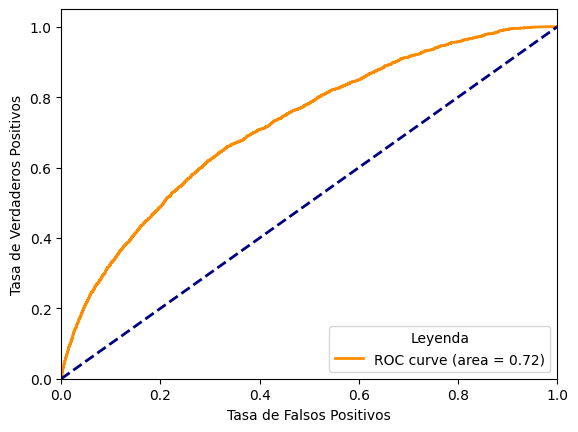

0.7197185619776758

In [ ]:
plot_roc_curve(model_LR, X_test_scaled, y_test)

In [ ]:
y_pred = model_LR.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
results['Logistic Regression'] = {
    'Training Accuracy': model_LR.score(X_train_scaled, y_train),
    'Test Accuracy': model_LR.score(X_test_scaled, y_test),
    'True Positives': TP,
    'True Negatives': TN,
    'False Positives': FP,
    'False Negatives': FN,
    'Classification Report': classification_report(y_test, y_pred, output_dict=True)
}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Árboles de decision

Inicializamos el clasificador de árboles de decisión

In [ ]:
# Definir los parámetros a ajustar en el Grid Search
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Inicializar el clasificador de Árboles de Decisión
tree_classifier = DecisionTreeClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(estimator=tree_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

In [ ]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

Mejores parámetros encontrados:
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [ ]:
tree_classifier = DecisionTreeClassifier(max_depth=5, min_samples_leaf = 2, min_samples_split = 2 )

In [ ]:
tree_classifier.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2)

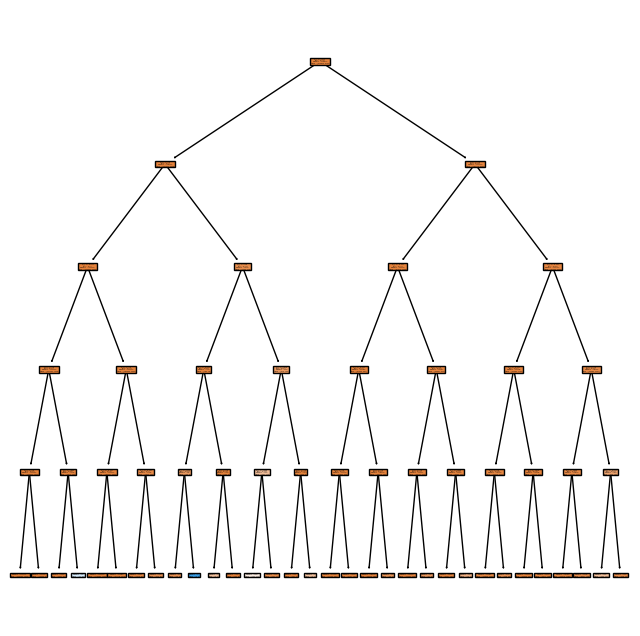

In [ ]:
fig = plt.figure(figsize=(8,8))
_ = plot_tree(tree_classifier, filled=True)

In [ ]:
predictions = tree_classifier.predict(X_test_scaled)

In [ ]:
print("Puntuación del conjunto de entrenamiento (Precisión) =", round(tree_classifier.score(X_train_scaled, y_train), 4))
print("Puntuación del conjunto de prueba (Precisión) =", round(tree_classifier.score(X_test_scaled, y_test), 4))

conf_mat = confusion_matrix(y_test, tree_classifier.predict(X_test_scaled))
print(tabulate(conf_mat,headers = ['pred Fraud No','pred Fraud Yes'], showindex = ['real Fraud No','real Fraud Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, tree_classifier.predict(X_test_scaled)))

Puntuación del conjunto de entrenamiento (Precisión) = 0.9845
Puntuación del conjunto de prueba (Precisión) = 0.9845
╒════════════════╤═════════════════╤══════════════════╕
│                │   pred Fraud No │   pred Fraud Yes │
╞════════════════╪═════════════════╪══════════════════╡
│ real Fraud No  │          153946 │               10 │
├────────────────┼─────────────────┼──────────────────┤
│ real Fraud Yes │            2420 │                5 │
╘════════════════╧═════════════════╧══════════════════╛
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    153956
           1       0.33      0.00      0.00      2425

    accuracy                           0.98    156381
   macro avg       0.66      0.50      0.50    156381
weighted avg       0.97      0.98      0.98    156381



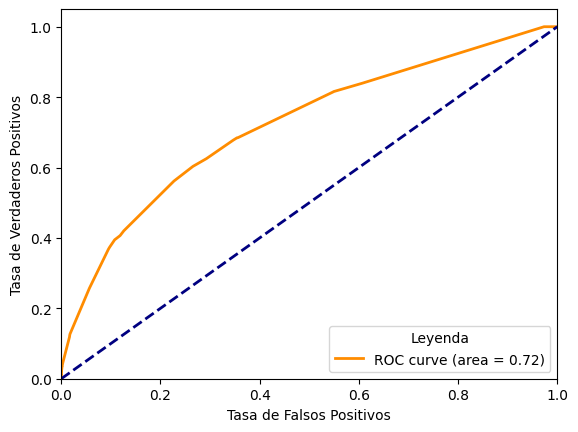

0.7196502120166614

In [ ]:
plot_roc_curve(tree_classifier, X_test_scaled, y_test)

## Random Forest

In [ ]:
model_rf = RandomForestClassifier()

# Definir los parámetros sobre los cuales se realizará el Grid Search
param_grid = {
    'n_estimators': [10, 50, 100],  # Número de árboles en el bosque
    'max_depth': [10, 20, 30, None],  # Profundidad máxima de cada árbol
}

In [ ]:
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'n_estimators': [10, 50, 100]},
             scoring='accuracy', verbose=1)

In [ ]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

Mejores parámetros encontrados:
{'max_depth': None, 'n_estimators': 50}


In [ ]:
# Entrenar el modelo con los datos
model_RF = RandomForestClassifier(max_depth = None, n_estimators = 50 )
model_RF.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=50)

In [ ]:
# Evaluar el modelo
y_pred = model_RF.predict(X_test_scaled)

In [ ]:
print("Puntuación del conjunto de entrenamiento (Precisión) =", round(model_RF.score(X_train_scaled, y_train), 4))
print("Puntuación del conjunto de prueba (Precisión) =", round(model_RF.score(X_test_scaled, y_test), 4))

conf_mat = confusion_matrix(y_test, model_RF.predict(X_test_scaled))
print(tabulate(conf_mat,headers = ['pred Fraud No','pred Fraud Yes'], showindex = ['real Fraud No','real Fraud Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_RF.predict(X_test_scaled)))

Puntuación del conjunto de entrenamiento (Precisión) = 0.9997
Puntuación del conjunto de prueba (Precisión) = 0.9847
╒════════════════╤═════════════════╤══════════════════╕
│                │   pred Fraud No │   pred Fraud Yes │
╞════════════════╪═════════════════╪══════════════════╡
│ real Fraud No  │          153950 │                6 │
├────────────────┼─────────────────┼──────────────────┤
│ real Fraud Yes │            2379 │               46 │
╘════════════════╧═════════════════╧══════════════════╛
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    153956
           1       0.88      0.02      0.04      2425

    accuracy                           0.98    156381
   macro avg       0.93      0.51      0.51    156381
weighted avg       0.98      0.98      0.98    156381



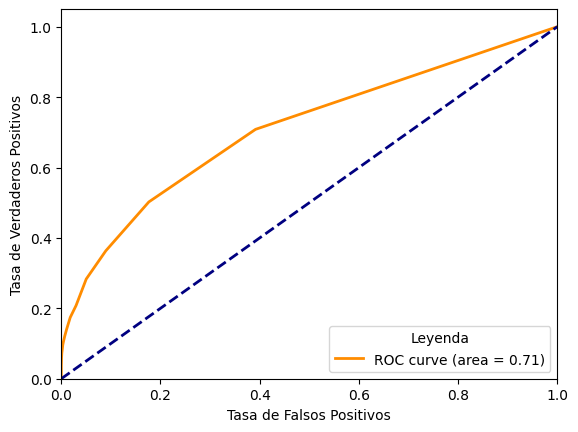

0.7097752470715291

In [ ]:
plot_roc_curve(model_RF, X_test_scaled, y_test)

In [ ]:
TN_rf, FP_rf, FN_rf, TP_rf = conf_mat.ravel()
results['Random Forest'] = {
    'Training Accuracy': model_RF.score(X_train, y_train),
    'Test Accuracy': model_RF.score(X_test, y_test),
    'True Positives': TP_rf,
    'True Negatives': TN_rf,
    'False Positives': FP_rf,
    'False Negatives': FN_rf,
    'Classification Report': classification_report(y_test, y_pred, output_dict=True)
}

## K-Nearest Neighbors (KNN)

In [ ]:
model_KNN = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [5, 10, 15],  # Reducir el número de vecinos a evaluar
    'weights': ['uniform', 'distance'],  # Mantener ambos tipos de ponderación
    'metric': ['euclidean', 'manhattan']  # Reducir las métricas de distancia
}

In [ ]:
grid_search = GridSearchCV(estimator=model_KNN, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)


In [ ]:
best_model = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)

In [ ]:
model_KNN = KNeighborsClassifier(n_neighbors=10)
model_KNN.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
print("Puntuación del conjunto de entrenamiento (Precisión) =", round(model_KNN.score(X_train_scaled, y_train), 4))
print("Puntuación del conjunto de prueba (Precisión) =", round(model_KNN.score(X_test_scaled, y_test), 4))

conf_mat = confusion_matrix(y_test, model_KNN.predict(X_test_scaled))
print(tabulate(conf_mat,headers = ['pred Fraud No','pred Fraud Yes'], showindex = ['real Fraud No','real Fraud Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_KNN.predict(X_test_scaled)))

Puntuación del conjunto de entrenamiento (Precisión) = 0.9845
Puntuación del conjunto de prueba (Precisión) = 0.9847
╒════════════════╤═════════════════╤══════════════════╕
│                │   pred Fraud No │   pred Fraud Yes │
╞════════════════╪═════════════════╪══════════════════╡
│ real Fraud No  │          153977 │               12 │
├────────────────┼─────────────────┼──────────────────┤
│ real Fraud Yes │            2381 │               11 │
╘════════════════╧═════════════════╧══════════════════╛
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    153989
           1       0.48      0.00      0.01      2392

    accuracy                           0.98    156381
   macro avg       0.73      0.50      0.50    156381
weighted avg       0.98      0.98      0.98    156381



In [ ]:
plot_roc_curve(model_KNN, X_test_scaled, y_test)

In [ ]:
TN_rf, FP_rf, FN_rf, TP_rf = conf_mat.ravel()
results['K-Nearest Neighbors'] = {
    'Training Accuracy': model.score(X_train_scaled, y_train),
    'Test Accuracy': model.score(X_test_scaled, y_test),
    'True Positives': TP_rf,
    'True Negatives': TN_rf,
    'False Positives': FP_rf,
    'False Negatives': FN_rf,
    'Classification Report': classification_report(y_test, model.predict(X_test_scaled), output_dict=True)
}

## MLP for Classification

In [ ]:
MLP_Clas = Sequential()
# Añadimos capas ocultas
MLP_Clas.add(Dense(10, input_shape=(103, ), activation='sigmoid'))
MLP_Clas.add(BatchNormalization())

MLP_Clas.add(Dense(16, activation='sigmoid'))
MLP_Clas.add(BatchNormalization())
# MLP_Clas.add(Dropout(0.2))

MLP_Clas.add(Dense(10, activation='sigmoid'))
# Output layer
MLP_Clas.add(Dense(1, activation='sigmoid'))

# Learning rate and optimizer
learning_rate = 0.1
optimizer = Adam(learning_rate=learning_rate)

# compile the keras model
MLP_Clas.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', Recall()]) # metrics=['accuracy']

history_clas = MLP_Clas.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=90, batch_size=30)
# evaluate the keras model
_, accuracy_tr, recall_tr = MLP_Clas.evaluate(X_train_scaled, y_train)
_, accuracy_ts, recall_ts = MLP_Clas.evaluate(X_test_scaled, y_test)
print('Accuracy train: %.2f; Recall train: %.2f' % (accuracy_tr*100, recall_tr*100))
print('Accuracy test: %.2f; Recall test: %.2f' % (accuracy_ts*100, recall_ts*100))

Epoch 1/90
20851/20851 [==============================] - 71s 3ms/step - loss: 0.0828 - accuracy: 0.9845 - recall_6: 1.0307e-04 - val_loss: 0.0876 - val_accuracy: 0.9845 - val_recall_6: 0.0000e+00
Epoch 2/90
20851/20851 [==============================] - 70s 3ms/step - loss: 0.0826 - accuracy: 0.9845 - recall_6: 0.0000e+00 - val_loss: 0.0802 - val_accuracy: 0.9845 - val_recall_6: 0.0000e+00
Epoch 3/90
20851/20851 [==============================] - 71s 3ms/step - loss: 0.0828 - accuracy: 0.9845 - recall_6: 0.0000e+00 - val_loss: 0.0943 - val_accuracy: 0.9845 - val_recall_6: 0.0000e+00
Epoch 4/90
20851/20851 [==============================] - 69s 3ms/step - loss: 0.0829 - accuracy: 0.9845 - recall_6: 0.0000e+00 - val_loss: 0.0817 - val_accuracy: 0.9845 - val_recall_6: 0.0000e+00
Epoch 5/90
20851/20851 [==============================] - 73s 4ms/step - loss: 0.0827 - accuracy: 0.9845 - recall_6: 0.0000e+00 - val_loss: 0.0800 - val_accuracy: 0.9845 - val_recall_6: 0.0000e+00
Epoch 6/90
2085

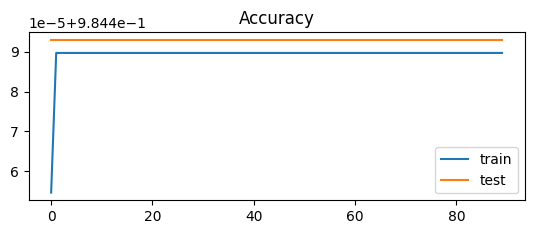

In [ ]:
plt.subplot(211)
plt.title('Accuracy')
plt.plot(history_clas.history['accuracy'], label='train')
plt.plot(history_clas.history['val_accuracy'], label='test')
plt.legend()

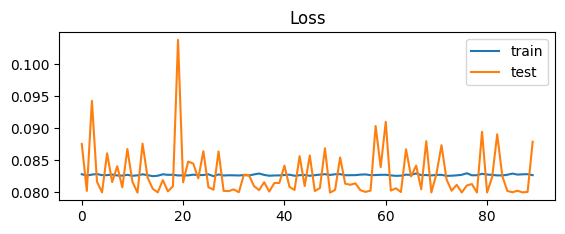

In [ ]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history_clas.history['loss'], label='train')
plt.plot(history_clas.history['val_loss'], label='test')
plt.legend()

In [ ]:
predictions = MLP_Clas.predict(X_test_scaled, verbose = 0).round(0)
conf_mat = confusion_matrix(y_test, predictions)
print(tabulate(conf_mat,headers = ['pred Diabetes No','pred Diabetes Yes'], showindex = ['real Diabetes No','real Diabetes Yes'],
               tablefmt = 'fancy_grid'))

print(classification_report(y_test, predictions))

╒═══════════════════╤════════════════════╤═════════════════════╕
│                   │   pred Diabetes No │   pred Diabetes Yes │
╞═══════════════════╪════════════════════╪═════════════════════╡
│ real Diabetes No  │             153956 │                   0 │
├───────────────────┼────────────────────┼─────────────────────┤
│ real Diabetes Yes │               2425 │                   0 │
╘═══════════════════╧════════════════════╧═════════════════════╛


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99    153956
           1       0.00      0.00      0.00      2425

    accuracy                           0.98    156381
   macro avg       0.49      0.50      0.50    156381
weighted avg       0.97      0.98      0.98    156381



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
summary_table = pd.DataFrame({
    'Model': [key for key in results.keys()],
    'Training Accuracy': [value['Training Accuracy'] for value in results.values()],
    'Test Accuracy': [value['Test Accuracy'] for value in results.values()],
    'True Positives': [value['True Positives'] for value in results.values()],
    'True Negatives': [value['True Negatives'] for value in results.values()],
    'False Positives': [value['False Positives'] for value in results.values()],
    'False Negatives': [value['False Negatives'] for value in results.values()],
})
